In [113]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import hvplot.pandas

In [135]:
import nasdaqdatalink
import os
from dotenv import load_dotenv

In [136]:
nasdaqdatalink.ApiConfig.api_key = "jZh4kTZdBvtrnEN-rdyz"

In [142]:
gdp_data = nasdaqdatalink.get("FRED/GDP")
gdp_data /= 1000
gdp_data.rename(columns = {"Value": "GDP"}, inplace = True)
    
cpi_data = nasdaqdatalink.get("FRED/CPIAUCSL")
cpi_data.rename(columns = {"Value": "Inflation"}, inplace = True)
    
econ_data = pd.concat([gdp_data, cpi_data], axis = 1)

econ_data.dropna(inplace = True)
econ_data

,GDP,Inflation
Date,,
1947-01-01,0.243164,21.480
1947-04-01,0.245968,22.000
1947-07-01,0.249585,22.230
1947-10-01,0.259745,22.910
1948-01-01,0.265742,23.680
...,...,...
2020-10-01,21.477597,260.352
2021-01-01,22.038226,262.200
2021-04-01,22.740959,266.727


In [143]:
# econ_data = pd.read_csv(
#     Path('US inflation & GDP - 2004.csv'),
#     index_col = "DATE", 
#     parse_dates = True, 
#     infer_datetime_format = True
# )


#Calculate the growth rate of economic data
econ_data["Inflation_Growth"] = econ_data["Inflation"].pct_change()
econ_data["GDP_Growth"] = econ_data["GDP"].pct_change()

econ_data.dropna(inplace = True)

#Calculate the 1st derivative of economic data
econ_data["Speed_of_Inflation_Growth"] = econ_data["Inflation_Growth"].pct_change()
econ_data["Speed_of_GDP_Growth"] = econ_data["GDP_Growth"].pct_change()

econ_data.dropna(inplace = True)

#Display economic data
display(econ_data)

,GDP,Inflation,Inflation_Growth,GDP_Growth,Speed_of_Inflation_Growth,Speed_of_GDP_Growth
Date,,,,,,
1947-07-01,0.249585,22.230,0.010455,0.014705,-0.568147,0.275238
1947-10-01,0.259745,22.910,0.030589,0.040708,1.925932,1.768250
1948-01-01,0.265742,23.680,0.033610,0.023088,0.098743,-0.432832
1948-04-01,0.272567,23.820,0.005912,0.025683,-0.824094,0.112386
1948-07-01,0.279196,24.400,0.024349,0.024321,3.118508,-0.053039
...,...,...,...,...,...,...
2020-10-01,21.477597,260.352,0.006997,0.016038,-0.268328,-0.811946
2021-01-01,22.038226,262.200,0.007098,0.026103,0.014461,0.627558
2021-04-01,22.740959,266.727,0.017265,0.031887,1.432410,0.221585


In [145]:
#Visualize the economic data
econ_graph = econ_data.hvplot.scatter(
    title='', 
    x='Date',
    y=['Inflation_Growth','GDP_Growth'])

econ_graph

:NdOverlay   [Variable]
   :Scatter   [Date]   (value)

In [146]:
for index, row in econ_data.iterrows():
    if (econ_data.loc[index, 'Speed_of_GDP_Growth'] < 0 and econ_data.loc[index, 'Speed_of_Inflation_Growth'] < 0):
        econ_data.loc[index, 'stageindex'] = 1
        econ_data.loc[index, 'stage'] = 'Reflation'
    if (econ_data.loc[index, 'Speed_of_GDP_Growth'] > 0 and econ_data.loc[index, 'Speed_of_Inflation_Growth'] < 0):
        econ_data.loc[index, 'stageindex'] = 2
        econ_data.loc[index, 'stage'] = 'Recovery'
    if (econ_data.loc[index, 'Speed_of_GDP_Growth'] > 0 and econ_data.loc[index, 'Speed_of_Inflation_Growth'] > 0):
        econ_data.loc[index, 'stageindex'] = 3
        econ_data.loc[index, 'stage'] = 'Overheat'
    if (econ_data.loc[index, 'Speed_of_GDP_Growth'] < 0 and econ_data.loc[index, 'Speed_of_Inflation_Growth'] > 0):
        econ_data.loc[index, 'stageindex'] = 4
        econ_data.loc[index, 'stage'] = 'Stagflation'

econ_data.replace([np.inf, -np.inf], 0, inplace = True)

print(econ_data["stageindex"].unique())

[2. 3. 4. 1.]


<AxesSubplot:xlabel='Date'>

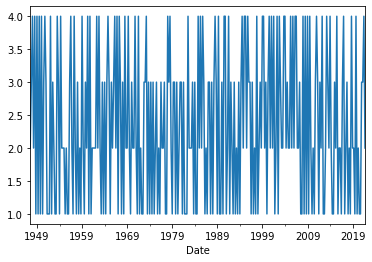

In [147]:
# list = []
# for i in econ_data["stage"]:
#     if i == "Recovery":
#         list.append(1)
#     if i == "Overheat":
#         list.append(2)
#     if i == "Stagflation":
#         list.append(3)
#     if i == "Reflation":
#         list.append(4)
# plt.plot(list)
econ_data["stageindex"].plot()

In [148]:
#Slice stage data out
stage_df = econ_data[["stageindex","stage"]]

stage_df

,stageindex,stage
Date,,
1947-07-01,2.0,Recovery
1947-10-01,3.0,Overheat
1948-01-01,4.0,Stagflation
1948-04-01,2.0,Recovery
1948-07-01,4.0,Stagflation
...,...,...
2020-10-01,1.0,Reflation
2021-01-01,3.0,Overheat
2021-04-01,3.0,Overheat


In [149]:
#Import data from Yahoo Finance
def stock_df(ticker, start, end):
    stock = yf.Ticker(ticker)
    stock_df = stock.history(start = start, end = end, interval = "1mo")
    return stock_df

start = pd.to_datetime('2004-01-01')
end = pd.to_datetime('today')
                     
#Check Website: https://medium.com/@richardhwlin/how-does-investment-clock-work-c7d8fbbeb7bd

#Import Communication data from Yahoo Finance
IYZ_df = stock_df('IYZ', start, end)
#Import Consumer Discretionary data from Yahoo Finance
IYC_df = stock_df('IYC', start, end)
#Import Consumer Staples data from Yahoo Finance
IYK_df = stock_df('IYK', start, end)
#Import Energy data from Yahoo Finance
IYE_df = stock_df('IYE', start, end)
#Import Financials data from Yahoo Finance
IYF_df = stock_df('IYF', start, end)
#Import HealthCare data from Yahoo Finance
IYH_df = stock_df('IYH', start, end)
#Import Industrials data from Yahoo Finance
IYJ_df = stock_df('IYJ', start, end)
#Import Materials data from Yahoo Finance
IYM_df = stock_df('IYM', start, end)
#Import Real Estate data from Yahoo Finance
IYR_df = stock_df('IYR', start, end)
#Import Technology data from Yahoo Finance
IYW_df = stock_df('IYW', start, end)
#Import Utility data from Yahoo Finance
IDU_df = stock_df('IDU', start, end)
#Import Bond data from Yahoo Finance
AGG_df = stock_df('AGG', start, end)


In [150]:
#Find the daily return of the stock in percentage

IYZ_df['Actual Return'] = IYZ_df["Close"].pct_change()
IYC_df['Actual Return'] = IYC_df["Close"].pct_change()
IYK_df['Actual Return'] = IYK_df["Close"].pct_change()
IYE_df['Actual Return'] = IYE_df["Close"].pct_change()
IYF_df['Actual Return'] = IYF_df["Close"].pct_change()
IYH_df['Actual Return'] = IYH_df["Close"].pct_change()
IYJ_df['Actual Return'] = IYJ_df["Close"].pct_change()
IYM_df['Actual Return'] = IYM_df["Close"].pct_change()
IYR_df['Actual Return'] = IYR_df["Close"].pct_change()
IYW_df['Actual Return'] = IYW_df["Close"].pct_change()
IDU_df['Actual Return'] = IDU_df["Close"].pct_change()
AGG_df['Actual Return'] = AGG_df["Close"].pct_change()

#Slice the daily return and the closing price of each ETF
IYZ_df_price_return = IYZ_df[["Actual Return"]]
IYZ_df_price_return = IYZ_df_price_return.dropna()

IYC_df_price_return = IYC_df[["Actual Return"]]
IYC_df_price_return = IYC_df_price_return.dropna()

IYK_df_price_return = IYK_df[["Actual Return"]]
IYK_df_price_return = IYK_df_price_return.dropna()

IYE_df_price_return = IYE_df[["Actual Return"]]
IYE_df_price_return = IYE_df_price_return.dropna()

IYF_df_price_return = IYF_df[["Actual Return"]]
IYF_df_price_return = IYF_df_price_return.dropna()

IYH_df_price_return = IYH_df[["Actual Return"]]
IYH_df_price_return = IYH_df_price_return.dropna()

IYJ_df_price_return = IYJ_df[["Actual Return"]]
IYJ_df_price_return = IYJ_df_price_return.dropna()

IYM_df_price_return = IYM_df[["Actual Return"]]
IYM_df_price_return = IYM_df_price_return.dropna()

IYR_df_price_return = IYR_df[["Actual Return"]]
IYR_df_price_return = IYR_df_price_return.dropna()

IYW_df_price_return = IYW_df[["Actual Return"]]
IYW_df_price_return = IYW_df_price_return.dropna()

IDU_df_price_return = IDU_df[["Actual Return"]]
IDU_df_price_return = IDU_df_price_return.dropna()

AGG_df_price_return = AGG_df[["Actual Return"]]
AGG_df_price_return = AGG_df_price_return.dropna()

#rename the ETF returnIYZ_df_price_return.rename(columns = {'Actual Return':'IYZ_return'}, inplace = True)
IYC_df_price_return.rename(columns = {'Actual Return':'IYC_return'}, inplace = True)
IYK_df_price_return.rename(columns = {'Actual Return':'IYK_return'}, inplace = True)
IYE_df_price_return.rename(columns = {'Actual Return':'IYE_return'}, inplace = True)
IYF_df_price_return.rename(columns = {'Actual Return':'IYF_return'}, inplace = True)
IYH_df_price_return.rename(columns = {'Actual Return':'IYH_return'}, inplace = True)
IYJ_df_price_return.rename(columns = {'Actual Return':'IYJ_return'}, inplace = True)
IYM_df_price_return.rename(columns = {'Actual Return':'IYM_return'}, inplace = True)
IYR_df_price_return.rename(columns = {'Actual Return':'IYR_return'}, inplace = True)
IYW_df_price_return.rename(columns = {'Actual Return':'IYW_return'}, inplace = True)
IDU_df_price_return.rename(columns = {'Actual Return':'IDU_return'}, inplace = True)
AGG_df_price_return.rename(columns = {'Actual Return':'AGG_return'}, inplace = True)



#Concat ETF return data
etf_data_return = pd.concat([IYZ_df_price_return,IYC_df_price_return,IYK_df_price_return,IYE_df_price_return,IYF_df_price_return,IYH_df_price_return,IYJ_df_price_return,IYM_df_price_return,IYR_df_price_return,IYW_df_price_return,IDU_df_price_return,AGG_df_price_return],
                            axis=1)

#Drop all N/A in the ETF return data
etf_data_return.dropna(inplace = True)
display(etf_data_return)

,IYZ_return,IYC_return,IYK_return,IYE_return,IYF_return,IYH_return,IYJ_return,IYM_return,IYR_return,IYW_return,IDU_return,AGG_return
Date,,,,,,,,,,,,
2004-02-01,0.031438,0.033358,0.039967,0.049193,0.023470,0.011709,-0.005237,0.052692,0.018004,-0.030891,0.018585,0.008674
2004-03-01,-0.030479,-0.000877,-0.002941,-0.008542,-0.007072,-0.037236,-0.012756,-0.027760,0.040696,-0.030446,0.003683,0.007175
2004-04-01,-0.001648,-0.021212,0.033779,0.027437,-0.053735,0.029840,-0.003382,-0.048863,-0.138505,-0.063014,-0.030519,-0.028186
2004-05-01,-0.025557,-0.004665,-0.012786,-0.010846,0.025990,0.000339,0.024959,0.021806,0.068099,0.060054,0.010230,-0.003958
2004-06-01,0.018598,0.002884,0.013919,0.058602,0.002344,-0.006435,0.053532,0.047321,0.015990,0.022703,0.008926,0.006792
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,-0.033962,-0.011918,-0.021165,-0.048602,-0.053127,-0.036667,-0.046296,-0.021168,-0.024126,0.026819,-0.018378,0.002706
2021-12-01,0.071289,0.013147,0.107007,0.005008,0.026160,0.078567,0.062683,0.071450,0.083497,0.013147,0.082110,-0.004449
2022-01-01,-0.057512,-0.096451,0.014391,0.173704,-0.000596,-0.075493,-0.045956,-0.060325,-0.072833,-0.082351,-0.032923,-0.017595


In [151]:
#Slice ETF data out to make it match with stage data

etf_data_return_slice = etf_data_return["2004-03-01":"2021-11-01"]

display(etf_data_return_slice)

,IYZ_return,IYC_return,IYK_return,IYE_return,IYF_return,IYH_return,IYJ_return,IYM_return,IYR_return,IYW_return,IDU_return,AGG_return
Date,,,,,,,,,,,,
2004-03-01,-0.030479,-0.000877,-0.002941,-0.008542,-0.007072,-0.037236,-0.012756,-0.027760,0.040696,-0.030446,0.003683,0.007175
2004-04-01,-0.001648,-0.021212,0.033779,0.027437,-0.053735,0.029840,-0.003382,-0.048863,-0.138505,-0.063014,-0.030519,-0.028186
2004-05-01,-0.025557,-0.004665,-0.012786,-0.010846,0.025990,0.000339,0.024959,0.021806,0.068099,0.060054,0.010230,-0.003958
2004-06-01,0.018598,0.002884,0.013919,0.058602,0.002344,-0.006435,0.053532,0.047321,0.015990,0.022703,0.008926,0.006792
2004-07-01,0.040403,-0.044488,-0.068064,0.034707,-0.020424,-0.053122,-0.030700,-0.018901,0.015564,-0.086721,0.015212,0.009263
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.024435,0.007546,0.016332,-0.075738,0.016863,0.050170,0.015392,0.024184,0.052156,0.038982,0.045163,0.011272
2021-08-01,0.019805,0.020484,0.000858,-0.017222,0.030653,0.024128,0.017315,0.000000,0.019397,0.048745,0.036569,-0.002085
2021-09-01,-0.059420,-0.030109,-0.037309,0.076571,-0.025729,-0.057875,-0.064677,-0.064092,-0.058829,-0.064313,-0.065467,-0.009177


In [152]:
#Concat ETF data with Stage data

etf_data_return_stage = pd.concat([etf_data_return_slice,stage_df], axis = 1)

display(etf_data_return_stage)

,IYZ_return,IYC_return,IYK_return,IYE_return,IYF_return,IYH_return,IYJ_return,IYM_return,IYR_return,IYW_return,IDU_return,AGG_return,stageindex,stage
Date,,,,,,,,,,,,,,
1947-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Recovery
1947-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Overheat
1948-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Stagflation
1948-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Recovery
1948-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Stagflation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.024435,0.007546,0.016332,-0.075738,0.016863,0.050170,0.015392,0.024184,0.052156,0.038982,0.045163,0.011272,4.0,Stagflation
2021-08-01,0.019805,0.020484,0.000858,-0.017222,0.030653,0.024128,0.017315,0.000000,0.019397,0.048745,0.036569,-0.002085,NaN,NaN
2021-09-01,-0.059420,-0.030109,-0.037309,0.076571,-0.025729,-0.057875,-0.064677,-0.064092,-0.058829,-0.064313,-0.065467,-0.009177,NaN,NaN


In [153]:
#Find the mean return of each ETF in each stage
etf_mean_return_stage = etf_data_return_stage.groupby(['stage']).mean()

etf_mean_return_stage

,IYZ_return,IYC_return,IYK_return,IYE_return,IYF_return,IYH_return,IYJ_return,IYM_return,IYR_return,IYW_return,IDU_return,AGG_return,stageindex
stage,,,,,,,,,,,,,
Overheat,0.024824,0.020848,0.019359,0.035731,0.025821,0.024757,0.026383,0.037526,0.037185,0.031642,0.034327,0.005333,3.0
Recovery,0.019831,0.031332,0.024700,0.065480,0.023533,0.016405,0.027099,0.035501,0.032517,0.028611,0.026721,0.003838,2.0
Reflation,0.012181,0.016251,0.014308,0.002166,0.014842,0.010799,0.018194,0.014557,0.021215,0.023880,0.019211,0.005435,1.0
Stagflation,-0.002597,-0.006006,0.004678,-0.033572,0.005382,0.014429,-0.009952,-0.014629,0.024715,-0.005936,0.016190,0.007150,4.0


In [154]:
#Visualize the return-stage data
etf_mean_return_stage_without_stageindex = etf_mean_return_stage.drop(columns = "stageindex")

Mean_return_stage_graph = etf_mean_return_stage_without_stageindex.hvplot.scatter(
    title='Mean return of ETFs since 2004', 
    x='stage')

Mean_return_stage_graph

:NdOverlay   [Variable]
   :Scatter   [stage]   (value)

In [155]:
#Drop stage column from the dataframe

etf_data_return_stageindex = etf_data_return_stage.drop(columns = "stage")

etf_data_return_stageindex

,IYZ_return,IYC_return,IYK_return,IYE_return,IYF_return,IYH_return,IYJ_return,IYM_return,IYR_return,IYW_return,IDU_return,AGG_return,stageindex
Date,,,,,,,,,,,,,
1947-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1947-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1948-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1948-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1948-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,0.024435,0.007546,0.016332,-0.075738,0.016863,0.050170,0.015392,0.024184,0.052156,0.038982,0.045163,0.011272,4.0
2021-08-01,0.019805,0.020484,0.000858,-0.017222,0.030653,0.024128,0.017315,0.000000,0.019397,0.048745,0.036569,-0.002085,NaN
2021-09-01,-0.059420,-0.030109,-0.037309,0.076571,-0.025729,-0.057875,-0.064677,-0.064092,-0.058829,-0.064313,-0.065467,-0.009177,NaN


In [156]:
# Assign a copy of the technical variable columns to a new DataFrame called `X` and lag it.
X = econ_data[["Speed_of_Inflation_Growth", "Speed_of_GDP_Growth"]].shift().dropna().copy()
display(X)

,Speed_of_Inflation_Growth,Speed_of_GDP_Growth
Date,,
1947-10-01,-0.568147,0.275238
1948-01-01,1.925932,1.768250
1948-04-01,0.098743,-0.432832
1948-07-01,-0.824094,0.112386
1948-10-01,3.118508,-0.053039
...,...,...
2020-10-01,-1.955853,-1.914224
2021-01-01,-0.268328,-0.811946
2021-04-01,0.014461,0.627558


In [157]:
#Buy signal for price change >1%
#Sell signal for price change <0%
#Hold Signal for price change is between 0% and 1%
# Initialize the new `Signal` column
#Suppose commission is 1%
# econ_data['Signal'] = 0.0
# econ_data.loc[(spy_df['Actual Return']*100 > 1), 'Signal'] = 1
# econ_data.loc[(spy_df['Actual Return']*100  < 1), 'Signal'] = 0
# econ_data.loc[(spy_df['Actual Return']*100 < 0), "Signal"] = -1


# Copy the new "stageindex" column to a new Series called `y`.
y = econ_data['stageindex'][1:]
display(y)

Date
1947-10-01    3.0
1948-01-01    4.0
1948-04-01    2.0
1948-07-01    4.0
1948-10-01    1.0
             ... 
2020-10-01    1.0
2021-01-01    3.0
2021-04-01    3.0
2021-07-01    4.0
2021-10-01    2.0
Freq: 3MS, Name: stageindex, Length: 297, dtype: float64

In [158]:
# Import the neccessary Date function
from pandas.tseries.offsets import DateOffset

# Use the following code to select the start of the training period: `training_begin = X.index.min()`
training_begin = X.index.min()
print(training_begin)

# Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
training_end = X.index.min() + DateOffset(months=5)
print(training_end)

# Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# Hint: Use `loc[training_begin:training_end]` for X_train and y_train
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# Hint: Use `loc[training_end:]` for X_test and y_test
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

1947-10-01 00:00:00
1948-03-01 00:00:00


In [82]:
X_test

,Speed_of_Inflation_Growth,Speed_of_GDP_Growth
DATE,,
2004-09-01,-0.500529,0.213151
2004-10-01,4.996829,0.140985
2004-11-01,0.661398,0.076517
2004-12-01,-0.104717,0.016217
2005-01-01,-1.000000,-0.049395
...,...,...
2021-07-01,0.249776,0.162746
2021-08-01,-0.482889,0.121727
2021-09-01,-0.264524,0.141371


In [100]:
print(y.unique())

[ 1.  2.  0.  3. nan]


In [83]:
y_test

2004-09-01    2.0
2004-10-01    2.0
2004-11-01    1.0
2004-12-01    0.0
2005-01-01    0.0
             ... 
2021-07-01    1.0
2021-08-01    1.0
2021-09-01    2.0
2021-10-01    2.0
2021-11-01    1.0
Name: stageindex, Length: 210, dtype: float64

In [91]:
test_df = pd.concat([X_test, y_test], axis = 1)
test_df[test_df.isnull().any(axis = 1)]

,Speed_of_Inflation_Growth,Speed_of_GDP_Growth,stageindex
2007-12-27,NaN,NaN,NaN
2014-12-24,NaN,NaN,NaN
2015-12-24,NaN,NaN,NaN


In [53]:
y_resampled.size

6

In [159]:
# Use StandardScaler to scale the X_train and X_test data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from imblearn.over_sampling import RandomOverSampler
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [160]:
# Create the classifier model.
from sklearn.svm import SVC
model = SVC()
 
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00         1
         4.0       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [161]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

In [162]:
# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        93
         2.0       0.00      0.00      0.00        74
         3.0       0.24      0.98      0.39        62
         4.0       0.22      0.15      0.18        66

    accuracy                           0.24       295
   macro avg       0.12      0.28      0.14       295
weighted avg       0.10      0.24      0.12       295



C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)
# Create a new empty predictions DataFrame using code provided below.


              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        77
         2.0       0.23      0.69      0.34        51
         3.0       0.29      0.41      0.34        39
         4.0       0.00      0.00      0.00        40

    accuracy                           0.25       207
   macro avg       0.13      0.27      0.17       207
weighted avg       0.11      0.25      0.15       207



C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahe04\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns'] = testing_signal_predictions
predictions_df['predicted_returns'].value_counts()

1.0    152
2.0     55
Name: predicted_returns, dtype: int64

In [110]:
predictions_df['actual_returns'] = spy_df['Actual Return']
predictions_df['trading_algorithm_returns'] = (predictions_df['actual_returns'] * predictions_df['predicted_returns'])
predictions_df

NameError: name 'spy_df' is not defined

In [111]:
(1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot()

KeyError: "None of [Index(['actual_returns', 'trading_algorithm_returns'], dtype='object')] are in the [columns]"